In [5]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from skopt import BayesSearchCV
import pandas as pd
from sklearn.metrics import precision_recall_curve, auc, roc_curve, confusion_matrix, f1_score, roc_auc_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import GroupKFold
from sklearn.feature_extraction.text import TfidfVectorizer


In [6]:
matrix = pd.read_csv('/home/jsearle/bigDrive/NAX/NLP-SAH_identification/featureMatrix/2_keyword_matrix_comb.csv', index_col=0)
y_data = matrix[['BDSPPatientID', 'NoteTitle', 'annot']]

tfidf_vectorizer = TfidfVectorizer(max_features=750, ngram_range=(1, 3))
X = tfidf_vectorizer.fit_transform(matrix['text'])
# X = matrix.drop(columns=['BDSPPatientID', 'NoteDate', 'NoteTitle', 'text', 'annot'])

In [7]:
y = y_data['annot']
y.head()

0    0
1    0
2    0
3    0
4    0
Name: annot, dtype: int64

In [8]:
all_predictions = []
all_true_labels = []
all_row_numbers = []

# outer loop
auc_cv = []
auc_pr = []
f1_cv = []
cf_cv = []
final_Cs = []
final_l1 = []
predictions = []
roc_curves = []
pr_curves = []

# Get feature names from TF-IDF vectorizer
feature_names = tfidf_vectorizer.get_feature_names_out()

# Dictionary to store feature importances
feature_importances_dict = {feature: [] for feature in feature_names}

# Initialize KFold
gkf = GroupKFold(n_splits=5)

for train_index, test_index in gkf.split(X, y, groups=y_data['BDSPPatientID']):
    Xtr, Xte = X[train_index], X[test_index]
    ytr, yte = y.iloc[train_index], y.iloc[test_index]

    model = LogisticRegression(
        penalty='elasticnet',
        class_weight=None, random_state=2023,
        solver='saga', max_iter=10000
    )

    search_spaces = {
        'C': (1e-2, 1e+2, 'log-uniform'),
        'l1_ratio': (0.01, 0.99),
    }
    model_cv = BayesSearchCV(
        model,
        search_spaces,
        n_iter=50, scoring='roc_auc', n_jobs=15,
        cv=5, random_state=2023
    )
    model_cv.fit(Xtr, ytr)

    # Find the best hyperparameters and append them
    best_hparams = model_cv.best_params_
    best_C = best_hparams['C']
    best_l1_ratio = best_hparams['l1_ratio']
    final_Cs.append(best_C)
    final_l1.append(best_l1_ratio)

    model = model_cv.best_estimator_

    ytr_pred = model.predict_proba(Xtr)[:, 1]  # Xtr is training features, ytr is training labels, ytr_pred is training predictions = Prob(y=1|Xtr)
    yte_pred = model.predict_proba(Xte)[:, 1]  # Xte is testing features

    fpr, tpr, cutoffs = roc_curve(yte, yte_pred)
    best_cutoff = cutoffs[np.argmax(tpr - fpr)]
    yte_pred_bin = (yte_pred > best_cutoff).astype(int)
    auc_cv.append(roc_auc_score(yte, yte_pred))
    f1_cv.append(f1_score(yte, yte_pred_bin))
    cf_cv.append(confusion_matrix(yte, yte_pred_bin))
    predictions.append(yte_pred_bin)

    # Store the predictions and true labels for this fold
    all_predictions.extend(yte_pred_bin)
    all_true_labels.extend(yte)
    all_row_numbers.extend(y_data.iloc[test_index]['BDSPPatientID'])

    # Save info for the plots
    roc_curves.append((fpr, tpr, roc_auc_score(yte, yte_pred)))
    precision, recall, thresholds = precision_recall_curve(yte, yte_pred)
    pr_curves.append((recall, precision, auc(recall, precision)))
    auc_pr_loop = auc(recall, precision)
    auc_pr.append(auc_pr_loop)

    # Extract feature importances (coefficients)
    feature_importances = model.coef_[0]
    for feature, importance in zip(feature_names, feature_importances):
        feature_importances_dict[feature].append(importance)

    print("Feature importances for this fold:")
    print(pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False))

    print(auc_cv)
    print(auc_pr)

Feature importances for this fold:
          Feature  Importance
556           sah   36.529475
604  subarachnoid   25.318794
76       aneurysm   15.679836
287     hemorrhag   10.835275
139        cerebr    7.331247
..            ...         ...
722         which   -5.800380
432            no   -6.213953
217            ed   -6.465812
636          that   -8.094171
255       fractur  -30.928210

[750 rows x 2 columns]
[0.957949215591137]
[0.8575306491631067]
Feature importances for this fold:
          Feature  Importance
556           sah   31.661154
604  subarachnoid   24.140437
76       aneurysm   17.015264
139        cerebr    7.724339
287     hemorrhag    7.283416
..            ...         ...
234        famili   -3.393054
178         daili   -3.455467
111       bilater   -5.232238
432            no   -6.994717
255       fractur  -16.286502

[750 rows x 2 columns]
[0.957949215591137, 0.939511653718091]
[0.8575306491631067, 0.8763369168818143]
Feature importances for this fold:
      

In [9]:
print(np.mean(auc_cv))
print(np.mean(auc_pr))


0.9509001259687564
0.8598007366578813


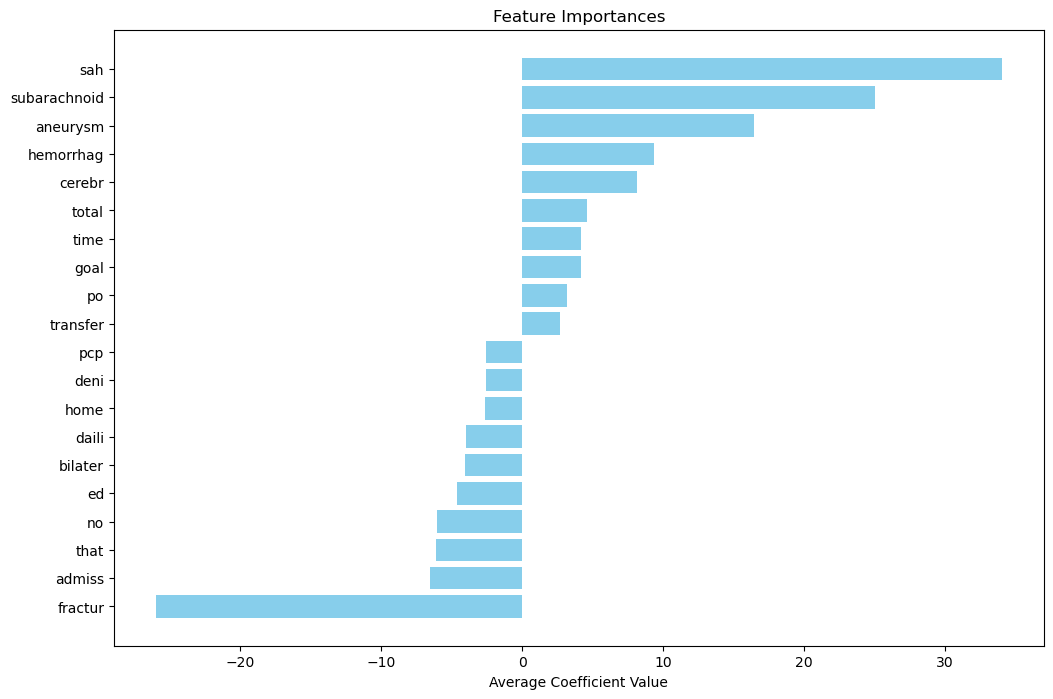

<Figure size 640x480 with 0 Axes>

In [10]:
# Aggregate feature importances by averaging over folds
avg_feature_importances = {feature: np.mean(importances) for feature, importances in feature_importances_dict.items()}
sorted_features = sorted(avg_feature_importances.items(), key=lambda item: item[1], reverse=True)
features, importances = zip(*sorted_features)

# Create a DataFrame of feature importances
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
})

# Save the DataFrame to a CSV file
feature_importance_df.to_csv('/home/jsearle/bigDrive/NAX/NLP-SAH_identification/model/results/TfidVec_BI_MGH/feat_importances.csv', index=False)

# Select top 10 and bottom 10 features
top_features = features[:10]
top_importances = importances[:10]
bottom_features = features[-10:]
bottom_importances = importances[-10:]

# Combine top and bottom features for plotting
plot_features = top_features + bottom_features
plot_importances = top_importances + bottom_importances

# Plot feature importances
plt.figure(figsize=(12, 8))
plt.barh(plot_features, plot_importances, color='skyblue')
plt.xlabel('Average Coefficient Value')
plt.title('Feature Importances')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
plt.show()

plt.savefig('/home/jsearle/bigDrive/NAX/NLP-SAH_identification/model/results/TfidVec_BI_MGH/feat_importances.png')

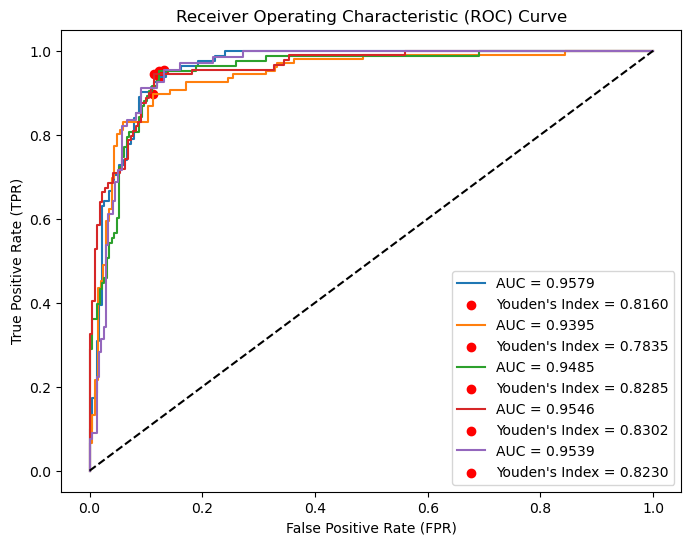

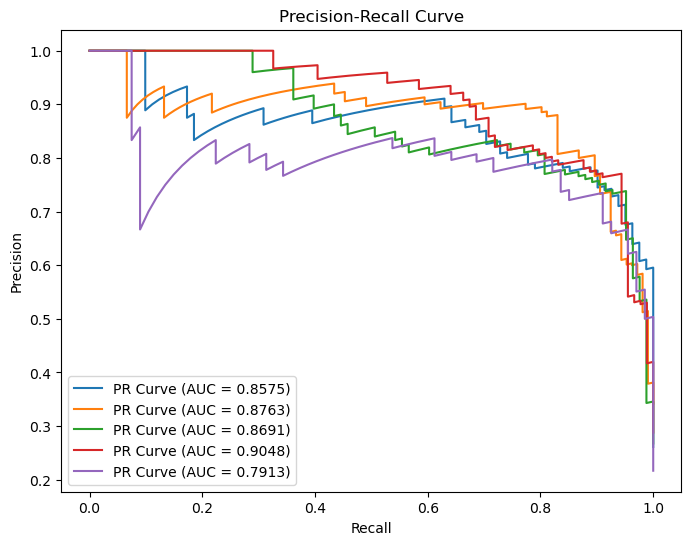

0.9509001259687564
0.8208161831483682


In [11]:
# Plot all ROC curves overlayed on a single graph
plt.figure(figsize=(8, 6))
for fpr, tpr, auc_score in roc_curves:
    plt.plot(fpr, tpr, label='AUC = {:.4f}'.format(auc_score))
    youden = np.max(tpr-fpr)
    plt.scatter(fpr[np.argmax(tpr-fpr)], tpr[np.argmax(tpr-fpr)], c='red', label=f'Youden\'s Index = {youden:.4f}')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line representing random classifier
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.savefig('/home/jsearle/bigDrive/NAX/NLP-SAH_identification/model/results/TfidVec_BI_MGH/AUC_iter.png')
plt.show()

# Plot all PR curves overlayed on a single graph
plt.figure(figsize=(8, 6))
for recall, precision, auc_pr_loop in pr_curves:
    plt.plot(recall, precision, label='PR Curve (AUC = {:.4f})'.format(auc_pr_loop))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.savefig('/home/jsearle/bigDrive/NAX/NLP-SAH_identification/model/results/TfidVec_BI_MGH/PR_iter.png')
plt.show()


# Create a DataFrame to hold the results
results_df = pd.DataFrame({'Unnamed: 0': all_row_numbers, 'annot': all_true_labels, 'prediction': all_predictions})

# Save the DataFrame to a CSV file
results_df.to_csv('/home/jsearle/bigDrive/NAX/NLP-SAH_identification/model/results/TfidVec_BI_MGH/LR_iter_pred_rr.csv', index=False)

# Calculate the final AUC and F1
auc_final = np.mean(auc_cv)
f1_final = np.mean(f1_cv)

# Save all the data
df = pd.DataFrame()
df['auc'] = auc_cv
df['f1s'] = f1_cv
df['auc_pr'] = auc_pr
df['C'] = final_Cs
df['l1_ratio'] = final_l1
df_pred = pd.DataFrame()
df1 = pd.DataFrame(predictions[0])
df2 = pd.DataFrame(predictions[1])
df3 = pd.DataFrame(predictions[2])
df4 = pd.DataFrame(predictions[3])
df5 = pd.DataFrame(predictions[4])
df_pred = pd.concat([df1,df2,df3,df4,df5]).reset_index()
df.to_csv('/home/jsearle/bigDrive/NAX/NLP-SAH_identification/model/results/TfidVec_BI_MGH/LR_iter.csv')

# Print final Data
print(auc_final)
print(f1_final)

In [12]:
print(final_Cs)
print(final_l1)

[3.276327084885787, 2.3240058552228695, 3.3738092283470476, 3.0311472534497463, 3.6146421638579387]
[0.99, 0.99, 0.99, 0.99, 0.99]


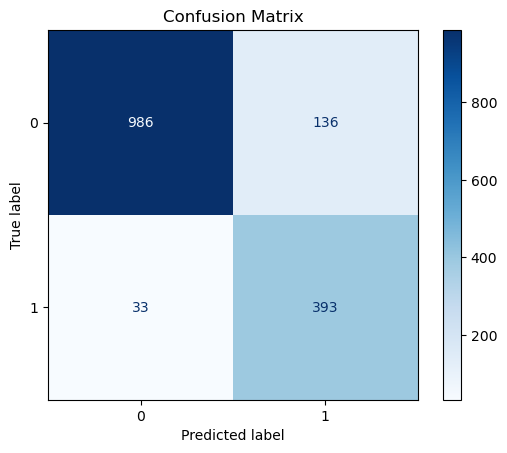

[[986 136]
 [ 33 393]]


In [13]:
# Create the confusion matrix
cf_matrix = confusion_matrix(all_true_labels, all_predictions)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.savefig('/home/jsearle/bigDrive/NAX/NLP-SAH_identification/model/results/TfidVec_BI_MGH/cf_matrix.png')
plt.show()

# Print the confusion matrix
print(cf_matrix)